Compute harmonic maps - use binning here instead of density compensation, which had issues normalizing to DC for H1

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.signal import find_peaks
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import clean_img
from nilearn.image import new_img_like
from sklearn.metrics import r2_score
from nilearn.image import mean_img
import os


In [2]:
# get subjects from subjects.txt:
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]

print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:2]
print(subjects)  


Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [3]:
nbins = 30


In [4]:
for subjectid in subjects:
    # file_path = fr"D:\hcp_processed\{subjectid}\harmonicDC7.nii.gz"
    # if os.path.exists(file_path):
    #     print(f"Skipping {subjectid}, file already exists.")
    #     continue  # Skip this subject
    # else:
    #     print(f"Processing {subjectid}...")

    print(f"subject {subjectid}")

    fmri_nifti_file = fr"D:\hcp_processed\{subjectid}\motion_corrected\{subjectid}_REST1_LR_mc.nii.gz"
    fmri_img = nib.load(fmri_nifti_file)

    # apply motion correction (load in the realigned data and apply motion regression)
    # fmri_mean_nifti = mean_img(fmri_img) # Compute mean fmri image before detrending
    # fmri_mean = np.mean(fmri_img.get_fdata(), axis=3)   # average over time

    # --- MOTION PARAMETERS REGRESSTION ---
    fmri_data = fmri_img.get_fdata()  # shape: (X, Y, Z, T)
    fmri_mean = np.nanmean(fmri_data, axis=3, keepdims=True) # get mean for normalization later

    ########################### CONVERT TO FRACTIONAL SIGNAL CHANGE HERE:
    fmri_data = fmri_data / fmri_mean 

    ##############################
    motion_array = np.load(fr"D:\hcp_processed\{subjectid}\motion_corrected\motion_array.npy")
    motion_deriv = np.vstack([np.zeros((1, 6)), np.diff(motion_array, axis=0)])
    motion_24reg = np.hstack([
        motion_array,
        motion_deriv,
        # motion_array ** 2,
        # motion_deriv ** 2
    ]) # shape: (T, 24)
    X, Y, Z, T = fmri_data.shape
    fmri_2d = fmri_data.reshape(-1, T).T  # shape: (T, V)
    # Add intercept (constant term)
    design_matrix = np.hstack([np.ones((T, 1)), motion_24reg])  # shape: (T, 25)
    # Solve linear regression: Y = X*B + E => E = residuals
    beta_hat = np.linalg.lstsq(design_matrix, fmri_2d, rcond=None)[0]  # shape: (25, V)
    predicted = design_matrix @ beta_hat  # shape: (T, V)
    residuals = fmri_2d - predicted  # shape: (T, V)
    residuals_4d = residuals.T.reshape(X, Y, Z, T) # the data with motion regression. 
    cleaned_img = nib.Nifti1Image(residuals_4d, affine=fmri_img.affine, header=fmri_img.header)
    fmri_img = cleaned_img
    # -- end motion correction ---

    # # High pass filtering 
    # high_pass = 0.0042
    # fmri_img = clean_img(fmri_img, detrend=True, high_pass = high_pass, standardize=False, t_r=TR)
    fmri_data = fmri_img.get_fdata()

    # load in the pulse information:
    output_dir = fr"D:\hcp_processed\{subjectid}"
    subject = f'{subjectid}_REST1_LR'
    save_path = os.path.join(output_dir, f"{subject}_cardiac_alignment_data.npz") # "D:\hcp_processed\100307\100307_REST1_LR_cardiac_alignment_data.npz
    cardiac_alignment_info = np.load(save_path, allow_pickle=True)

    # Get 3D aligned data:  
    fmri_slices = []
    theta_slices = []
    
    valid_fmri_indices_arr = cardiac_alignment_info["valid_fmri_indices"]
    # If it's a 0-D object array (rare), extract the Python object:
    if valid_fmri_indices_arr.ndim == 0 and valid_fmri_indices_arr.dtype == object:
        valid_fmri_indices_arr = valid_fmri_indices_arr.item()
    cardiac_phase_arr = cardiac_alignment_info["cardiac_phase"]
    # If it's a 0-D object array (rare), extract the Python object:
    if cardiac_phase_arr.ndim == 0 and cardiac_phase_arr.dtype == object:
        cardiac_phase_arr = cardiac_phase_arr.item()

    for slice_idx  in np.arange(fmri_data.shape[2]):
        fmri_data_2D = fmri_data[:,:,slice_idx,:]
        fmri_data_2D = fmri_data_2D.reshape(fmri_data.shape[0]*fmri_data.shape[1], fmri_data.shape[3])
        
        valid_fmri_indices = valid_fmri_indices_arr[slice_idx]
        cardiac_phase = cardiac_phase_arr[slice_idx]

        fmri_data_2D_trunc = fmri_data_2D[:, valid_fmri_indices]
        theta = cardiac_phase[valid_fmri_indices]  # Keep only valid phases
        fmri_data_2D = fmri_data[:,:,slice_idx,:]
        fmri_data_2D = fmri_data_2D.reshape(fmri_data.shape[0]*fmri_data.shape[1], fmri_data.shape[3])
        fmri_slices.append(fmri_data_2D_trunc.reshape(90, 104, -1))
        theta_slices.append(theta)

##################3
    # --- Harmonic maps from cardiac phase (per subject) ---
    # We assume: fmri_slices is a list of arrays [slice0, slice1, ...]
    #   where each item has shape (X, Y, T_slice), and theta_slices is a
    #   same-length list of 1D arrays of length T_slice (cardiac phase for kept frames).
    # We'll compute complex Fourier projections at k = 1, 2, 3 for each voxel.
    # Magnitude maps are saved as NIfTIs with the subject's affine/header.

    # Infer spatial dims from first slice:
    X_dim, Y_dim = fmri_slices[0].shape[:2]
    Z_dim = len(fmri_slices)

    # Prepare output volumes for each harmonic (magnitude)
    harmonics = [0, 1, 2, 3, 4, 5, 6] 

    harm_maps = {k: np.zeros((X_dim, Y_dim, Z_dim), dtype=np.float32) for k in harmonics}

    # Small helper: vectorized projection onto e^{-ikθ} with per-voxel mean removal
    def project_harmonics(data_xy_t, theta, ks):
        """
        data_xy_t: (V, T)  where V = X*Y flattened
        theta: (T,)
        ks: list of ints (harmonic numbers)
        Returns dict k -> magnitude array (V,)
        """
        # Remove DC per voxel to avoid bias
        data_xy_t_noncentered = data_xy_t
        mean = np.nanmean(data_xy_t, axis=1, keepdims=True)
        data_xy_t = data_xy_t - mean


        # data_xy_t = data_xy_t - np.nanmean(data_xy_t, axis=1, keepdims=True)

        # # Normalize each voxel’s time series by its DC mean
        # data_xy_t = data_xy_t / np.nanmean(data_xy_t, axis=1, keepdims=True)

        # Handle NaNs (if any) by masking timepoints that are NaN in any voxel
        # (conservative; typical cardiac-aligned data should be NaN-free)
        # If NaNs exist, drop those frames for all voxels to keep matrix ops simple
        valid_t = np.all(np.isfinite(data_xy_t), axis=0) & np.isfinite(theta)
        data = data_xy_t[:, valid_t]               # (V, T_valid)
        th = theta[valid_t]                        # (T_valid,)

############################################## --- NEED TO SORT DATA AND DTH IN ORDER OF ASCENDING THETA. ---
        sort_idx = np.argsort(th)
        # 2. Apply it to theta and data
        th_sorted = th[sort_idx]                  # (T_valid,)
        data_sorted = data[:, sort_idx]           # (V, T_valid)
        th = th_sorted
        data = data_sorted


################################### --- APPLY BINNING HERE, AVOID DENSITY COMPENSATION: --- 
        # re-make th and data:
        bins = np.linspace(0, 1, nbins + 1)       # bin edges in [0,1)
        bin_idx = np.digitize(th, bins) - 1       # (T_valid,) → which bin each sample belongs to

        # Prepare new arrays
        binned_th = np.zeros(nbins)

        binned_data = np.zeros((data.shape[0], nbins))
        for i in range(nbins):
            mask = bin_idx == i
            if np.any(mask):
                binned_th[i] = np.mean(th[mask])              # center of mass in that bin
                binned_data[:, i] = np.mean(data[:, mask], axis=1)
            else:
                binned_th[i] = (bins[i] + bins[i+1]) / 2      # empty bin = center of bin
                # binned_data[:, i] = 0                         # or np.nan if you prefer
        # --- Interpolate missing bins for binned_data along time axis (per voxel) ---
        for v in range(data.shape[0]):  # loop over voxels
            valid = ~np.isnan(binned_data[v])
            binned_data[v] = np.interp(
                x=np.arange(nbins),
                xp=np.where(valid)[0],
                fp=binned_data[v, valid],
            )
    ##################3 --- for DC components (k=0): ###########################
        data_noncentered = data_xy_t_noncentered[:, valid_t]
        binned_data_noncentered = np.zeros((data.shape[0], nbins))

        for i in range(nbins):
            mask = bin_idx == i
            if np.any(mask):
                binned_th[i] = np.mean(th[mask])              # center of mass in that bin
                binned_data_noncentered[:, i] = np.mean(data_noncentered[:, mask], axis=1)
            else:
                binned_th[i] = (bins[i] + bins[i+1]) / 2      # empty bin = center of bin
                # binned_data[:, i] = 0                         # or np.nan if you prefer

        # --- Interpolate missing bins for binned_data along time axis (per voxel) ---
        for v in range(data_noncentered.shape[0]):  # loop over voxels
            valid = ~np.isnan(binned_data_noncentered[v])
            binned_data_noncentered[v] = np.interp(
                x=np.arange(nbins),
                xp=np.where(valid)[0],
                fp=binned_data_noncentered[v, valid],
            )


    ##############################################################################################################
        # Replace original variables
        th = binned_th           # shape (nbins,)
        data = binned_data       # shape (V, nbins)
        data_noncentered = binned_data_noncentered

####################################################

        T_valid = data.shape[1]
        if T_valid == 0:
            return {k: np.zeros(data_xy_t.shape[0], dtype=np.float32) for k in ks}

        # get rid of the nan code above?
        # th = theta

        # Design vectors for each k: exp(-i k theta) of shape (T_valid,)
        # Projection coefficient per voxel: c_k = (1/T) * sum_t data_t * exp(-i k theta_t)
        # Vectorized via matrix multiply: (V,T) @ (T,) -> (V,)
        results = {}
        # for k in ks:
        #     # basis = np.exp(-1j * k * th)          # (T_valid,) # fourier basis function at harmonic k 
        #     basis = np.exp(-1j * k * th * 2 * np.pi)          # (T_valid,) # fourier basis function at harmonic k 
        #     # NEEDS DENSITY COMPONENSATION HERE? FOR EACH MULTIPLICATION NEED DENSITY COMPENSATION
        #     # dth = np.cat(th(0), th(0:) - th(1:))
        #     dth = np.gradient(th) # (T_valid,)

        #     # plot dth - distribution of how far away the points are from each other, how far one is to the next

        #     c_k = (data * dth) @ basis / np.mean(dth)

        #     # c_k = (data.*density @ basis)
        #     # c_k = (data @ basis) / T_valid        # (V,) # project time point onto the basis function, then normalize by number of phase points
        #     # Magnitude of complex coefficient as the harmonic amplitude
        #     results[k] = np.abs(c_k).astype(np.float32)
        #     # results[k] = np.abs(c_k).astype(np.float32)/mean.squeeze()

        # return results
        dth = np.gradient(th)              # (T_valid,)

        # --- PLOTTING DISITRIBUTION OF CARDIAC PHASE BETWEEN POINTS --- 
        # # plot dth - distribution of how far away the points are from each other, how far one is to the next
        # import matplotlib.pyplot as plt
        # plt.figure(figsize=(10,4))
        # plt.subplot(1,2,1)
        # # plt.plot(th, dth, '-o')
        # plt.scatter(th, dth) #, '-o')
        # plt.title("Local Spacing vs Phase")
        # plt.xlabel("Phase (θ)")
        # plt.ylabel("Δθ")
        # plt.subplot(1,2,2)
        # plt.hist(dth, bins=50)
        # plt.title("Distribution of Δθ")
        # plt.xlabel("Δθ")
        # plt.ylabel("Count")
        # plt.tight_layout()
        # plt.show()

        ### --- Debugging --- ######
        # print(f"np.sum(dth) {np.sum(dth)}") # should be ~1
        # print(f"th {th}") # 
        
        ###
        
        for k in ks:
            if k == 0:
                basis = np.exp(-1j * k * th * 2 * np.pi)          # (T_valid,) # fourier basis function at harmonic k 
                c_k = (data_noncentered * dth) @ basis / np.sum(dth) # (V,)
                results[k] = np.abs(c_k).astype(np.float32)
                continue

            # basis = np.exp(-1j * k * th)          # (T_valid,) # fourier basis function at harmonic k 
            basis = np.exp(-1j * k * th * 2 * np.pi)          # (T_valid,) # fourier basis function at harmonic k 
            # NEEDS DENSITY COMPONENSATION HERE (using dth): 
            c_k = (data * dth) @ basis / np.sum(dth) # (V,)
            results[k] = np.abs(c_k).astype(np.float32)
        return results
######################################################### end of project_harmonics ####################

    # print(fr"id: {subjectid}")
    # Process each slice independently
    for z_idx, (slice_data, theta) in enumerate(zip(fmri_slices, theta_slices)):
        # slice_data: (X, Y, Tz)
        Xs, Ys, Tz = slice_data.shape
        V = Xs * Ys
        data_flat = slice_data.reshape(V, Tz)   # (V, Tz)
        
        # print(fr"theta: {theta}")
        mags = project_harmonics(data_flat, theta, harmonics)        

        # Reshape back to (X,Y) and assign into 3D volumes
        for k in harmonics:
            harm_maps[k][:, :, z_idx] = mags[k].reshape(Xs, Ys)

    for k in harmonics:
        # harm_maps[k][:, :, :] = harm_maps[k][:, :, :] / fmri_mean.squeeze()
        harm_maps[k][:, :, :] = harm_maps[k][:, :, :] # / fmri_mean.squeeze()

    # Save NIfTIs for k = 1, 2, 3
    sub_out_dir = fr"D:\hcp_processed\{subjectid}"
    for k in harmonics:
        out_path = os.path.join(sub_out_dir, f"harmBin{k}_nbins{nbins}.nii.gz")
        nifti_k = nib.Nifti1Image(harm_maps[k], affine=fmri_img.affine, header=fmri_img.header)
        nib.save(nifti_k, out_path)
        print(f"Saved harmonic {k} map to: {out_path}")
    # --- end harmonic maps ---
# take fft of each 3d volume or of each 2d slice (they can have differing # of phase points)

# take 1st, 2nd, and 3rd harmonic of each voxel to get 3d map for each subject and for each harmonic

# save the 3 maps in subject folder, D:\hcp_processed\{subjectid}\harmonic{harm}.nii.gz

############################

subject 100307


C:\Users\march\AppData\Local\Temp\ipykernel_115328\3901623042.py:23: RuntimeWarning: invalid value encountered in divide
  fmri_data = fmri_data / fmri_mean
C:\Users\march\AppData\Local\Temp\ipykernel_115328\3901623042.py:112: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_xy_t, axis=1, keepdims=True)


Saved harmonic 0 map to: D:\hcp_processed\100307\harmBin0_nbins30.nii.gz
Saved harmonic 1 map to: D:\hcp_processed\100307\harmBin1_nbins30.nii.gz
Saved harmonic 2 map to: D:\hcp_processed\100307\harmBin2_nbins30.nii.gz
Saved harmonic 3 map to: D:\hcp_processed\100307\harmBin3_nbins30.nii.gz
Saved harmonic 4 map to: D:\hcp_processed\100307\harmBin4_nbins30.nii.gz
Saved harmonic 5 map to: D:\hcp_processed\100307\harmBin5_nbins30.nii.gz
Saved harmonic 6 map to: D:\hcp_processed\100307\harmBin6_nbins30.nii.gz
subject 101309
Saved harmonic 0 map to: D:\hcp_processed\101309\harmBin0_nbins30.nii.gz
Saved harmonic 1 map to: D:\hcp_processed\101309\harmBin1_nbins30.nii.gz
Saved harmonic 2 map to: D:\hcp_processed\101309\harmBin2_nbins30.nii.gz
Saved harmonic 3 map to: D:\hcp_processed\101309\harmBin3_nbins30.nii.gz
Saved harmonic 4 map to: D:\hcp_processed\101309\harmBin4_nbins30.nii.gz
Saved harmonic 5 map to: D:\hcp_processed\101309\harmBin5_nbins30.nii.gz
Saved harmonic 6 map to: D:\hcp_proc

subject 100307


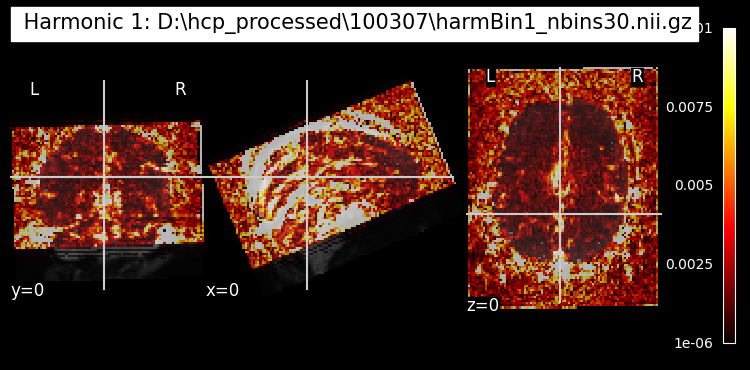

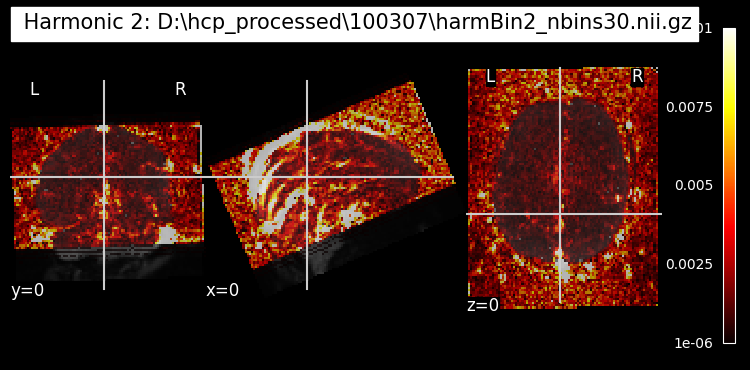

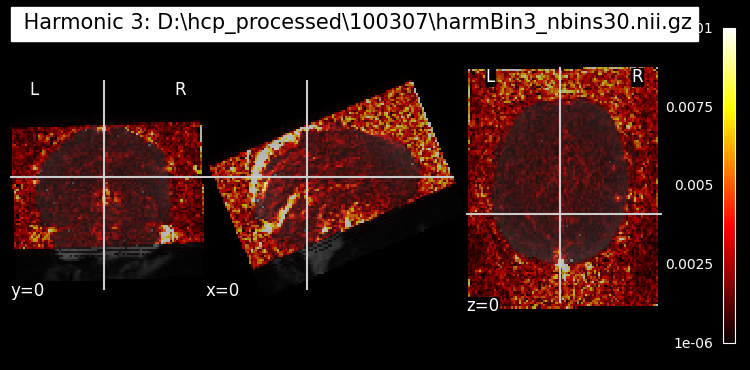

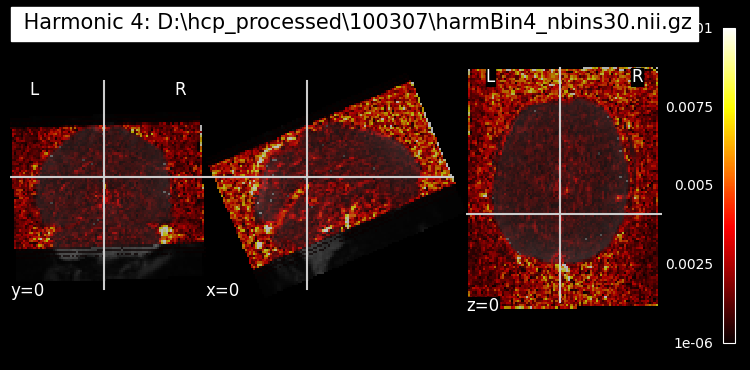

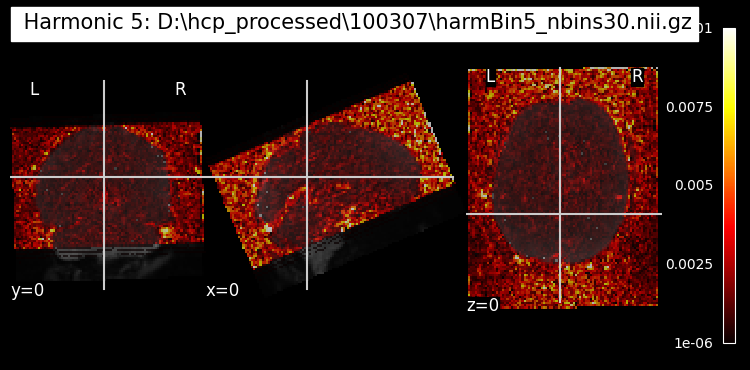

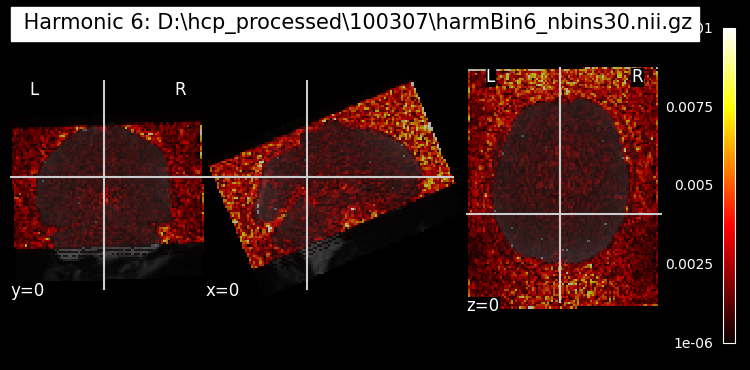

subject 101309


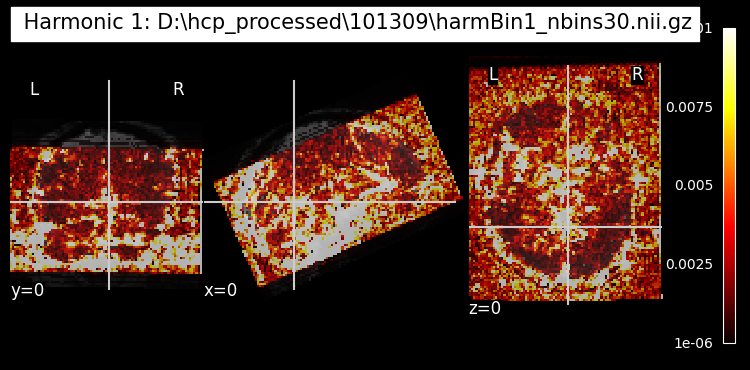

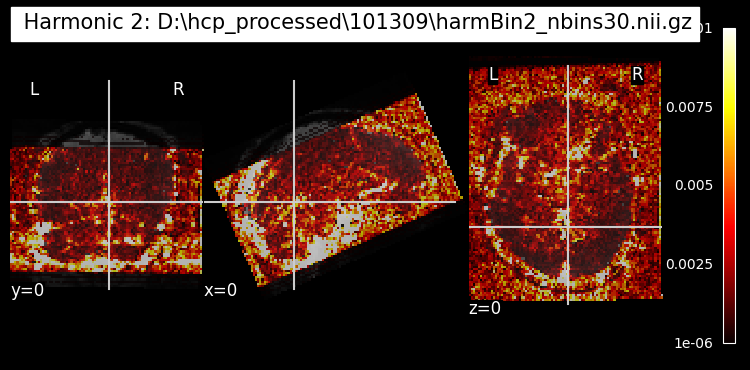

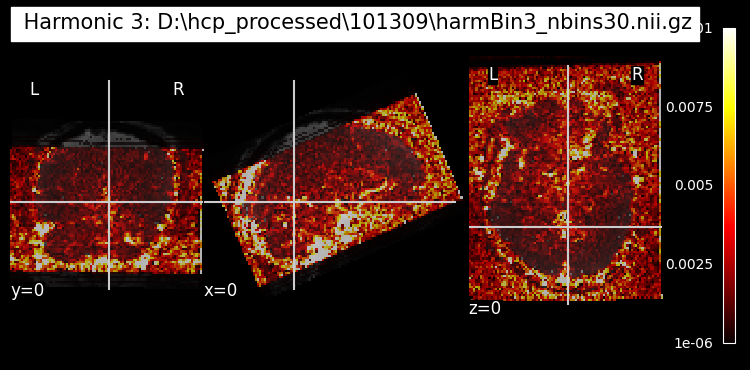

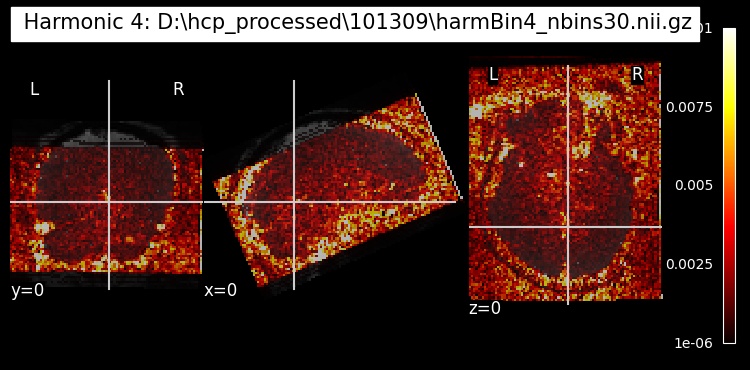

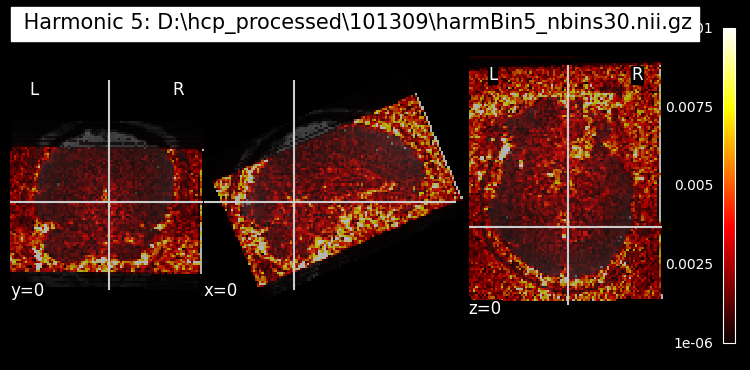

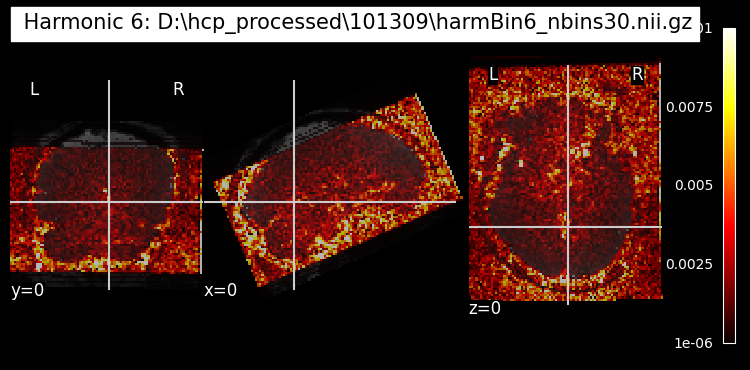

In [7]:
from nilearn import plotting
subjects_view = subjects[:2]

# check the results, loop through subjects and look at each harmonic map:
for subjectid in subjects_view:
    print(f"subject {subjectid}")
    # subject's mean image:
    mean_fmri_path = fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz"
    
    harmonics = [0, 1, 2, 3, 4, 5, 6]
    # harmonics = [1, 2, 3, 4, 5, 6, 7]

    sub_out_dir = fr"D:\hcp_processed\{subjectid}"
    for k in harmonics:
        out_path = os.path.join(sub_out_dir, f"harmBin{k}_nbins30.nii.gz")
        # nib.load(out_path)
        # Load and plot with nilearn
        # plotting.plot_img(out_path, title=f"Subject {subjectid} - Harmonic {k}")

        plotting.plot_stat_map(
        stat_map_img=out_path,
        bg_img=mean_fmri_path,
        # threshold=2,  # adjust based on intensity scale
        vmin = 0,
        vmax = 0.01, # 0.1
        title=f" Harmonic {k}: {out_path}",
        display_mode='ortho',
        cut_coords=(0, 0, 0),
        annotate=True,
        cmap="hot",
        alpha=0.7
        )
    plotting.show()

# plot MIPs?



In [8]:
# looking for nan's:
import numpy as np
import nibabel as nib
from nilearn import plotting
import os

subjects_view = subjects[:2]   # just testing

for subjectid in subjects_view:
    print(f"\n===== Subject {subjectid} =====")
    
    for k in [0,1,2,3,4,5,6]:
        path = fr"D:\hcp_processed\{subjectid}\harmBin{k}_nbins30.nii.gz"
        data = nib.load(path).get_fdata()

        n_nan = np.isnan(data).sum()
        n_zero = np.sum(data == 0)
        n_inf = np.sum(~np.isfinite(data))

        print(f"Harmonic {k}: NaNs={n_nan:,}  zeros={n_zero:,}  non-finite={n_inf:,}  shape={data.shape}")



===== Subject 100307 =====
Harmonic 0: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 1: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 2: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 3: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 4: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 5: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)
Harmonic 6: NaNs=0  zeros=187,200  non-finite=0  shape=(90, 104, 72)

===== Subject 101309 =====
Harmonic 0: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 1: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 2: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 3: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 4: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 5: NaNs=0  zeros=177,840  non-finite=0  shape=(90, 104, 72)
Harmonic 6: NaNs=0  zeros=177,840  non-finite=0